# Nonlinear Buckling of a Box Beam Reinforced with Ribs and Stiffeners

***

In this notebook we are going to investigate the nonlinear buckling behavior of a box beam reinforced with ribs and stiffeners.

* [Geometry and material properties](#geometry)
* [Setup of the numerical model](#numerical-model)
* [Mesh convergence study](#mesh-convergence)
* [Nonlinear analysis: sensitivity of nonlinear analysis parameters](#nonlinear-analysis-parameters)
    * [Error function](#error-function)
    * [Convergence tolerance](#convergence-tolerance)
    * [Initial load increment](#ninc)
    * [Desired number of iteration](#desiter)
    * [Minimum allowable arc-length adjustment ratio](#minalr)
    * [Maximum allowable arc-length adjustment ratio](#maxalr)
* [Nonlinear analysis: nonlinear buckling method verification](#nonlinear-buckling-method-verification)
* [Conclusion](#conclusion)

In [1]:
import matplotlib.pyplot as plt  # import matplotlib
import tol_colors as tc  # package for colorblind-friendly colors

plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('bright'))))  # set default color cycle to TOL bright
FIRST_SUBCASE_ID = 1  # id of the first subcase

## Geometry and material properties <a name="geometry"></a>

***

We consider an analogous reinforced box beam as in [notebook 8](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb). Besides ribs, this time we also reinforce the structure with a number of equally spaced stiffeners along the width of the box, both for the top and the bottom skin.

![Geometry of the box beam reinforced with stiffners.](resources/12_BoxBeamGeometry.svg "Geometry of the box beam reinforced with stiffners.")

Let's define the planform, cross-section and ribs distribution of our box beam. To calculate the location of the ribs along the length, we use the same ribs spacing of the [ribs-only reinforced box beam](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb). Analogously to our previous notebooks, we are going to use the _millimeter - newton - megapascal - ton_ system of units.

In [2]:
import numpy as np

AR = 9   # aspect ratio - 2*b/w (the length of the box beam corresponds to half the span of the CRM wing)
w = 1e3  # width [mm]
l = AR*w/2  # length [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
ribs_spacing = w/2  # half of box beam's width
no_ribs = int(np.ceil(l/ribs_spacing)) + 1  # calculate number of ribs
ribs_y_locations = np.linspace(0, l, no_ribs)  # calculate y-coordinates of the ribs

# Print information to screen
print(f"""Box beam dimensions:
- width: {w/1e3:.1f} m
- span: {l/1e3:.1f} m
- height: {h/1e3:.1f} m
- wall thickness: {t:.1f} mm""")
np.set_printoptions(precision=0)
print(f"Number of ribs: {no_ribs:d}")
print(f"Ribs y-coordinate [mm]:")
print(ribs_y_locations)

Box beam dimensions:
- width: 1.0 m
- span: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm
Number of ribs: 10
Ribs y-coordinate [mm]:
[   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500.]


Next we define the stiffners spacing dividing the ribs spacing by $1.4$. Considering the [analytical results for a thin plate under uniaxial compression](03_Equilibrium_Diagram_of_a_Thin_Plate_under_Uniaxial_Compression.ipynb#problem-definition) as a first order approximation, we do this with the aim of having the highest theoretical linear buckling load of the rib-stiffener bays for a buckling mode with one or two half waves. Even higher buckling loads can be obtained using an aspect ratio of the rib-stiffener bay smaller then 1, but that implies the use of a large number of ribs. This is typically avoided in aircraft design as it leads to a significant increase in weight.

In [3]:
stiffeners_spacing = ribs_spacing/1.4
no_stiffeners = round(w/stiffeners_spacing) - 1  # obtain number of stiffeners by dividing the width of the box beam by the stiffeners spacing
stiffeners_x_locations = np.linspace(0, w, no_stiffeners + 2)[1:-1]
print(f"Number of stiffeners: {no_stiffeners:d}")
print("Stiffeners x-coordinate [mm]:")
print(stiffeners_x_locations)

Number of stiffeners: 2
Stiffeners x-coordinate [mm]:
[333. 667.]


We note that our approach is not very accurate, as a rib-stiffener bay is not exactly the same thing of a simply supported plate. However, here we only want to obtain a vaguely reasonable value of the stiffeners' spacing, and we consider this approach satisfactory.

For the stiffeners, we set their height to $1/10$ of the box height and we use the same thickness of the box beam walls.

In [4]:
stiffeners_height = h/10
print(f"Stiffeners height: {stiffeners_height:.0f} mm")

Stiffeners height: 20 mm


Finally, we define the same material properties used in our previous notebooks.

In [5]:
rho = 2780e-12  # density [ton/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio

## Setup of the numerical model <a name="numerical-model"></a>

***

To generate the mesh of our box beam reinforced with ribs and stiffeners, we use the function `mesh_box_beam_reinforced_with_ribs_and_stiffeners` from the `box_beam_utils` module. This function employs the library `pyvista` to discretize the geometry and it enforces the discretization of every edge into an odd number of nodes, which should result in a better approximation of the buckling modes with an odd number of half-waves. The final mesh is returned as a `PolyData` object. This object contains the coordinates of the nodes and their connectivity information.

For demonstration purposes only, let's select a shell element with a prescribed lenght equal to 1/4 of the height of the box beam and let's generate a mesh with only the root and tip ribs. We then plot the mesh using the `plot` method of the `PolyData` class. To visualize the mesh of the stiffeners it is necessary to zoom inside the box beam.

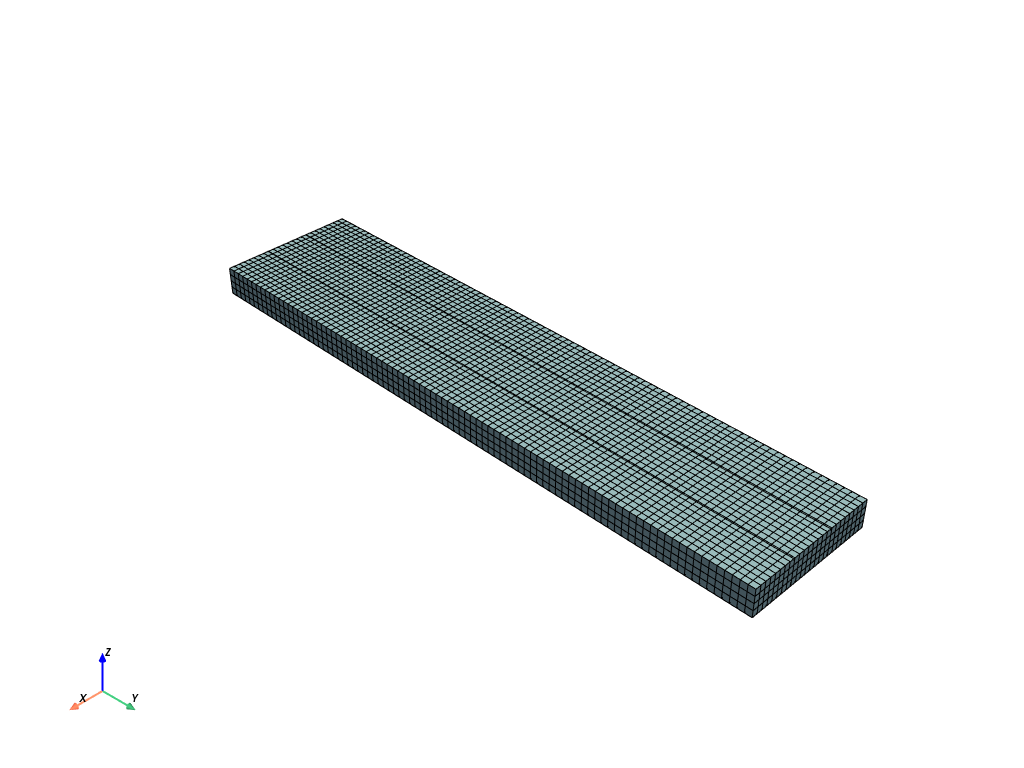

In [6]:
from resources import box_beam_utils

example_box_beam_mesh = box_beam_utils.mesh_box_beam_reinforced_with_ribs_and_stiffeners(
    width=w, height=h, ribs_y_coordinates=[0., l], stiffeners_x_coordinates=stiffeners_x_locations,
    stiffeners_height=stiffeners_height, element_length=h/4)
example_box_beam_mesh.plot(show_edges=True, jupyter_backend='static')

Following the mesh we need to create a base bdf input, that we will complete each time depending on the analysis we want to perform. For this purpose we use the function `create_base_bdf_input` from the `box_beam_utils` module. This function takes as input the material properties, the wall thickness, the nodes' coordinates and their connectivity matrix, and it returns a `BDF` object containing the base bdf input.

Let's find the nodes' coordinates and the connectivity matrix from the example mesh created earlier, call `create_base_bdf_input` and print a summary of our bdf input.

In [7]:
nodes_xyz_array = example_box_beam_mesh.points  # Nx3 array with the xyz coordinates of the nodes
nodes_connectivity_matrix = example_box_beam_mesh.faces.reshape(-1, 5)[:, 1:]  # Nx4 array with the indices of the nodes defining each element in each row
example_bdf_input = box_beam_utils.create_base_bdf_input(
    young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_xyz_array,
    nodes_connectivity_matrix=nodes_connectivity_matrix)
print(example_bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 5962

bdf.elements: 0
  CQUAD4   : 5952

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Now it's time to define our load. Analogously to previous notebooks, we are going to consider a concentrated bending load applied at the tip, as shown below. We define the function `apply_tip_concentrated_load`, which performs the following steps:

- add a master node at the center of the tip section;
- connect the master node to the nodes on the edge of the tip rib with a `RBE3` element, which defines the motion at a reference grid point as the weighted average of the motions at a set of other grid points;
- apply a unitary vertical force at the master point with a `FORCE` card.

![Concentrated tip load.](resources/08_BoxBeamConcentratedLoad.svg "Concentrated tip load.")

In [8]:
from resources import pynastran_utils

def apply_tip_concentrated_load(bdf_input, force_id):
    # Add master node at the center of the tip section
    master_node_id = len(bdf_input.nodes) + 1
    bdf_input.add_grid(master_node_id, [w/2, l, 0.])
    # Find id of the nodes on the edge of the tip rib
    tolerance = t/10  # we define a geometric tolerance to find the nodes on the edge of the tip rib equal to 1/10 of the cross-sectional thickness
    tip_edge_nodes_ids = [nid for nid in bdf_input.nodes if (np.abs(bdf_input.nodes[nid].xyz[1] - l) < tolerance) & 
                          (np.abs((bdf_input.nodes[nid].xyz[0]) < tolerance) |
                           (np.abs(bdf_input.nodes[nid].xyz[0] - w) < tolerance) |
                           (np.abs(bdf_input.nodes[nid].xyz[2] - h/2) < tolerance) |
                           (np.abs(bdf_input.nodes[nid].xyz[2] + h/2) < tolerance))]
    # Add RBE3 to connect master node with edge nodes of tip rib
    rbe3_eid = len(bdf_input.elements) + 1
    bdf_input.add_rbe3(eid=rbe3_eid, refgrid=master_node_id, refc='123456', weights=[1.]*len(tip_edge_nodes_ids),
                       comps=['123456']*len(tip_edge_nodes_ids), Gijs=tip_edge_nodes_ids)
    # Add concentrated force
    force_direction = [0., 0., 1.]
    pynastran_utils.add_uniform_force(
        bdf=bdf_input, nodes_ids=[master_node_id], set_id=force_id, direction_vector=force_direction)
    # Return id of master node
    return master_node_id

## Mesh convergence study <a name="mesh-convergence"></a>

***

Analogously to our previous investigations on the [unreinforced box beam](04_Nonlinear_Buckling_Analysis_of_a_Box_Beam.ipynb#mesh-convergence) and on the [box beam reinforced with ribs](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb#mesh-convergence), we need perform a mesh convergence study to establish an appropriate mesh size for our analyses. For this reason, we define 10 different target lengths for the shell elements, evenly spaced on a log scale between the half the box beam's height and 1/6 of the stiffeners' height.

In [9]:
# Define shell elements' edge lengths to be used for the mesh convergence study and print them to screen
shell_element_lengths = np.geomspace(h/2, stiffeners_height/6, 10) # [mm]
print("Prescribed edge length of shell elements for mesh convergence study [mm]:")
np.printoptions(precision=1)
print(shell_element_lengths)

Prescribed edge length of shell elements for mesh convergence study [mm]:
[100.  69.  47.  32.  22.  15.  10.   7.   5.   3.]


We run the linear buckling analysis with SOL 105 for the different target element lengths and we monitor the critical buckling load.

subcase=0 already exists...skipping


Results of model with:
    - 100.0 mm maximum element length
    - 2184 elements
    - 12258 degrees of freedom
Buckling load: 8849 N
Buckling mode:


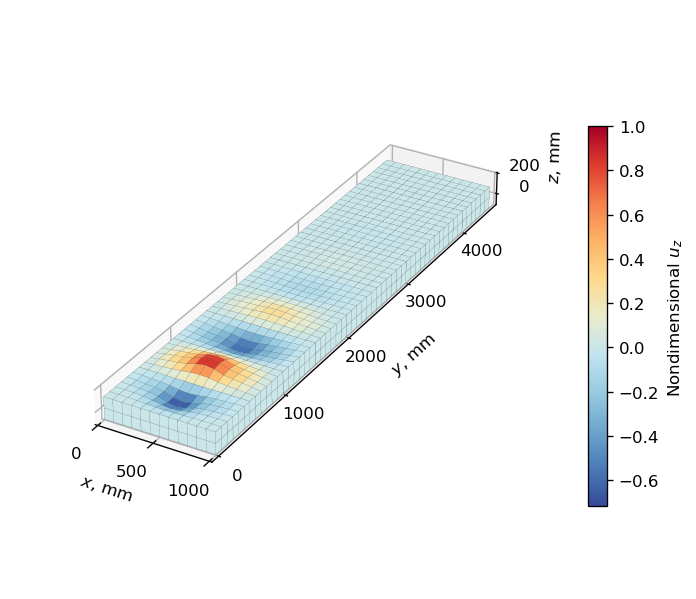

subcase=0 already exists...skipping


Nastran job linear_buckling_4464_elements.bdf completed
Wall time: 2.0 s
Results of model with:
    - 68.5 mm maximum element length
    - 4464 elements
    - 25218 degrees of freedom
Buckling load: 8554 N
Buckling mode:


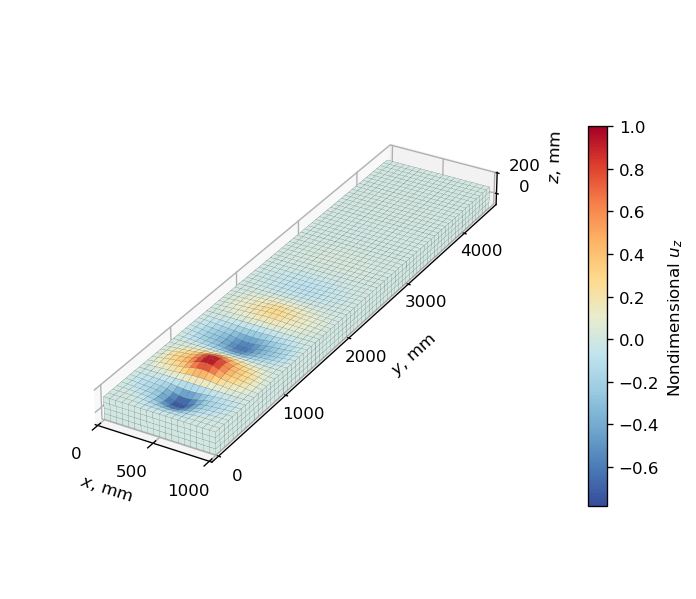

subcase=0 already exists...skipping


Nastran job linear_buckling_8784_elements.bdf completed
Wall time: 5.0 s
Results of model with:
    - 47.0 mm maximum element length
    - 8784 elements
    - 50274 degrees of freedom
Buckling load: 8424 N
Buckling mode:


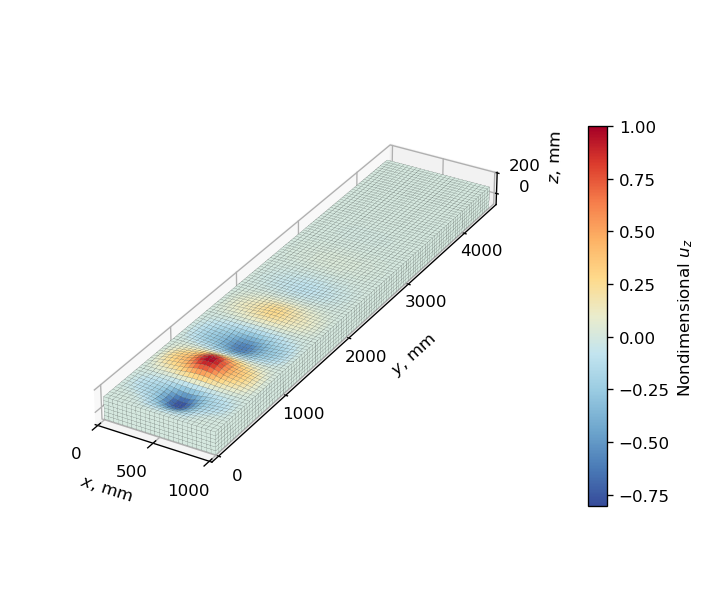

subcase=0 already exists...skipping


Nastran job linear_buckling_16704_elements.bdf completed
Wall time: 10.0 s
Results of model with:
    - 32.2 mm maximum element length
    - 16704 elements
    - 96174 degrees of freedom
Buckling load: 8382 N
Buckling mode:


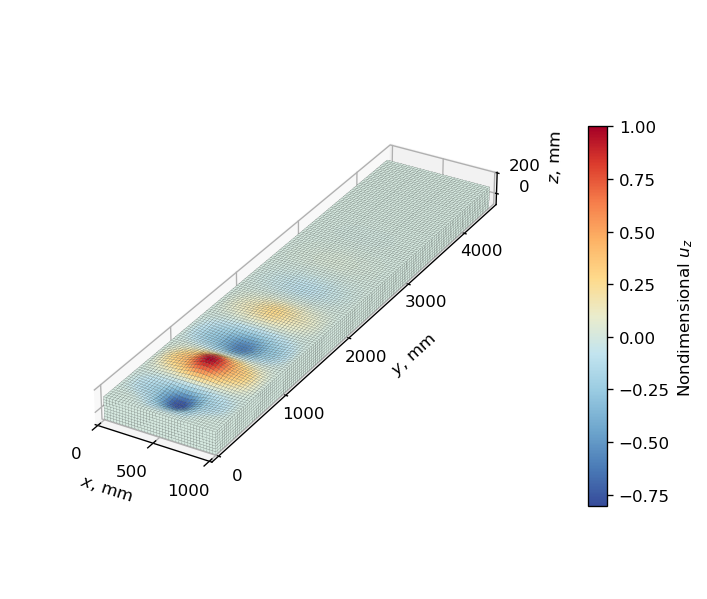

subcase=0 already exists...skipping


Nastran job linear_buckling_31584_elements.bdf completed
Wall time: 23.0 s
Results of model with:
    - 22.1 mm maximum element length
    - 31584 elements
    - 183330 degrees of freedom
Buckling load: 8468 N
Buckling mode:


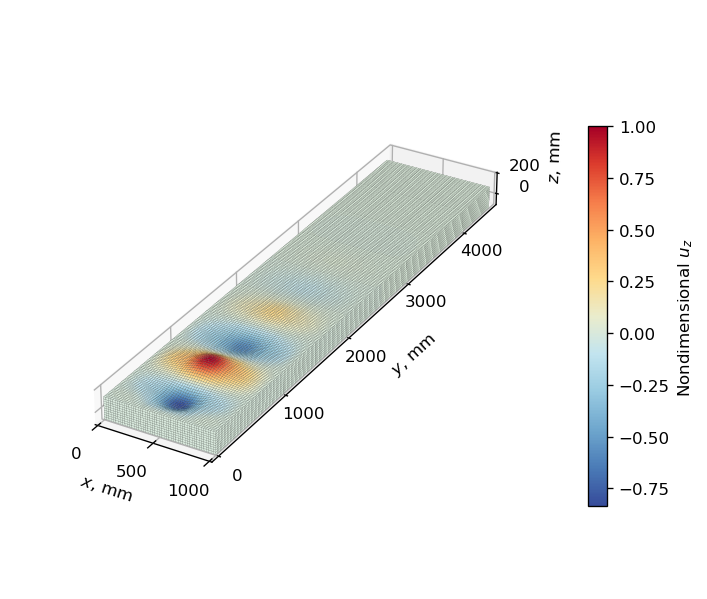

subcase=0 already exists...skipping


Nastran job linear_buckling_65160_elements.bdf completed
Wall time: 53.0 s
Results of model with:
    - 15.1 mm maximum element length
    - 65160 elements
    - 380322 degrees of freedom
Buckling load: 8358 N
Buckling mode:


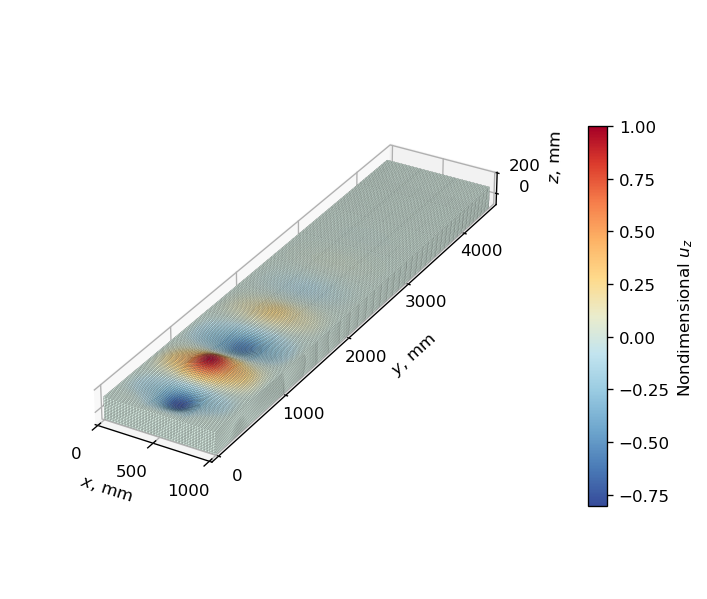

subcase=0 already exists...skipping


Nastran job linear_buckling_133800_elements.bdf completed
Wall time: 154.0 s
Results of model with:
    - 10.4 mm maximum element length
    - 133800 elements
    - 783594 degrees of freedom
Buckling load: 8460 N
Buckling mode:


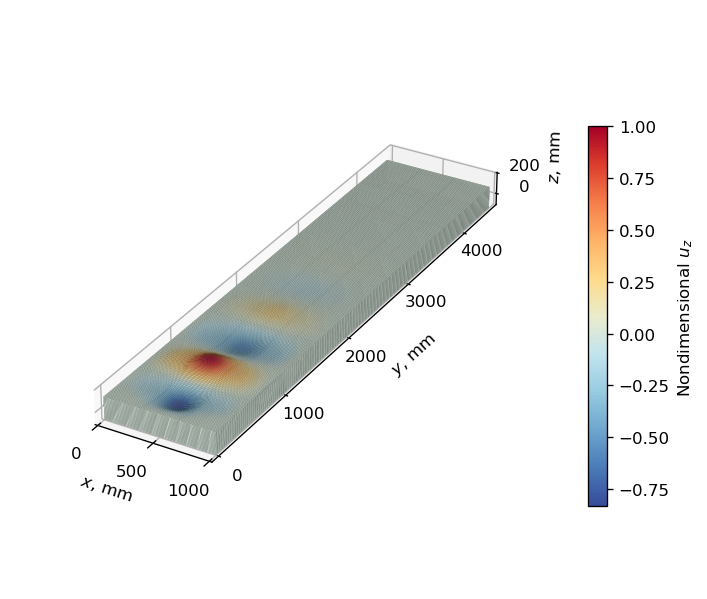

subcase=0 already exists...skipping


Nastran job linear_buckling_279072_elements.bdf completed
Wall time: 608.0 s
Results of model with:
    - 7.1 mm maximum element length
    - 279072 elements
    - 1638954 degrees of freedom
Buckling load: 8449 N
Buckling mode:


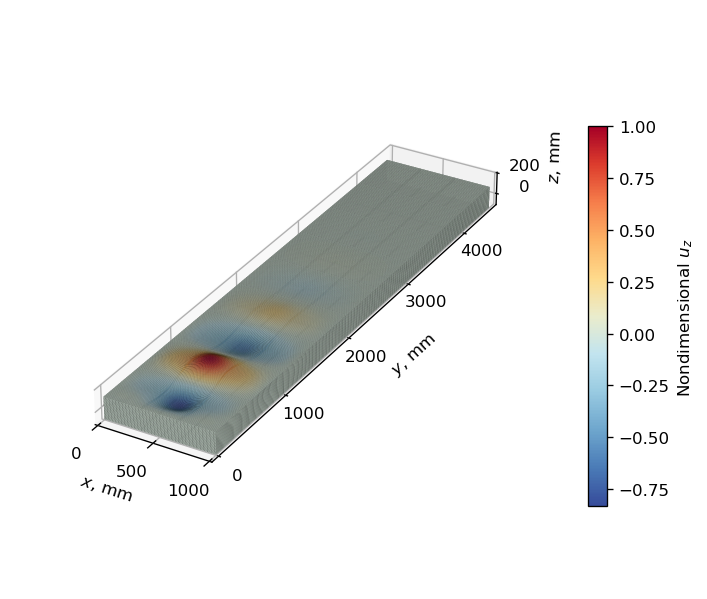

subcase=0 already exists...skipping


Nastran job linear_buckling_582408_elements.bdf completed
Wall time: 2252.0 s
Results of model with:
    - 4.9 mm maximum element length
    - 582408 elements
    - 3427974 degrees of freedom
Buckling load: 8351 N
Buckling mode:


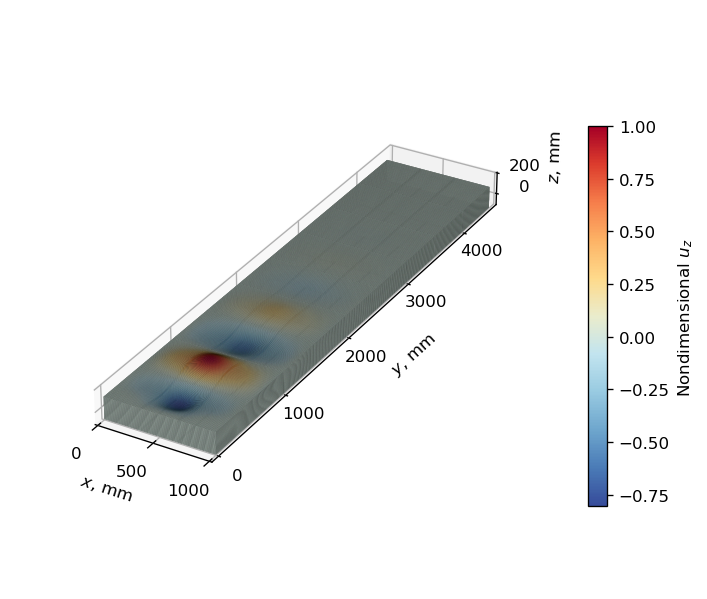

subcase=0 already exists...skipping


Nastran job linear_buckling_1184400_elements.bdf completed
Wall time: 8052.0 s
Results of model with:
    - 3.3 mm maximum element length
    - 1184400 elements
    - 6977718 degrees of freedom
Buckling load: 8451 N
Buckling mode:


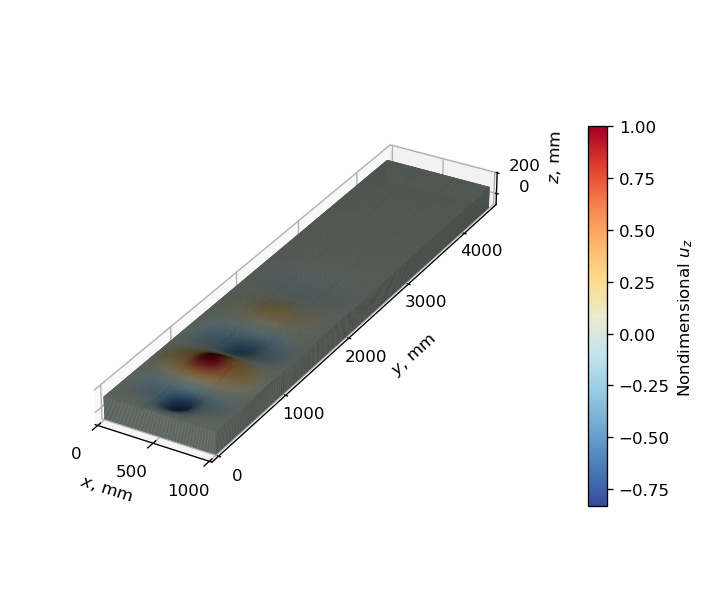

In [10]:
import os
from resources import plot_utils

plt.rcParams["figure.dpi"] = 120  # set default dpi of figures
AMPLIFICATION_FACTOR = 100  # amplification factor for displacements
force_set_id = 11  # define FORCE card identification number

# Initialize arrays with number of elements, number of degrees of freedom and linear buckling loads
no_elements = np.empty(np.shape(shell_element_lengths), dtype=int)
dofs = np.empty(np.shape(shell_element_lengths))
linear_buckling_loads = np.empty(np.shape(shell_element_lengths))

# Define name of analysis directory
analysis_directory_name = "12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners"
ANALYSIS_DIRECTORY_PATH = os.path.join(os.getcwd(), "analyses", analysis_directory_name)

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis='x', nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis='z', nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis='y', which='major', pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis='z', which='major', pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 60  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(-0.05, .14))  # move colorbar upwards

# Iterate through the different edge lengths
for count, element_length in enumerate(shell_element_lengths):
    # Generate bdf input
    box_beam_mesh = box_beam_utils.mesh_box_beam_reinforced_with_ribs_and_stiffeners(
        width=w, height=h, ribs_y_coordinates=ribs_y_locations, stiffeners_x_coordinates=stiffeners_x_locations,
        stiffeners_height=stiffeners_height, element_length=element_length)
    nodes_xyz_array = box_beam_mesh.points
    nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]
    linear_buckling_bdf = box_beam_utils.create_base_bdf_input(
        young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_xyz_array,
        nodes_connectivity_matrix=nodes_connectivity_matrix)
    
    # Store number of elements and number of degrees of freedom of current model
    no_elements[count] = len(linear_buckling_bdf.elements)
    constrained_nodes_ids = next(iter(linear_buckling_bdf.spcs.values()))[0].node_ids
    dofs[count] = (len(linear_buckling_bdf.nodes) - len(constrained_nodes_ids))*6
    
    # Apply uniform load over the top skin
    apply_tip_concentrated_load(linear_buckling_bdf, force_set_id)
    
    # Run SOL 105 and return OP2 object
    input_name = f"linear_buckling_{no_elements[count]:d}_elements"
    sol_105_op2 = pynastran_utils.run_sol_105(
        bdf=linear_buckling_bdf.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
        input_name=input_name, run_flag=False)
    
    # Find critical buckling load and print it
    print(f"""\033[1mResults of model with:
    - {element_length:.1f} mm maximum element length
    - {no_elements[count]:d} elements
    - {dofs[count]:.0f} degrees of freedom\033[0m""")
    linear_buckling_loads[count] = sol_105_op2.eigenvectors[2].eigr
    print(f"Buckling load: {linear_buckling_loads[count]:.0f} N")
    
    # Plot critical buckling mode
    print("Buckling mode:")
    _, ax, cbar = plot_utils.plot_eigenvector(
        op2=sol_105_op2, subcase_id=2, displacement_component='tz', colormap='sunset',
        displacement_amplification_factor=AMPLIFICATION_FACTOR, length_unit="mm")
    adjust_3d_plot(ax, cbar)
    plt.show()

We plot the buckling loads and the percentage difference with respect to the load obtained with the finest mesh against the number of degrees of freedom.

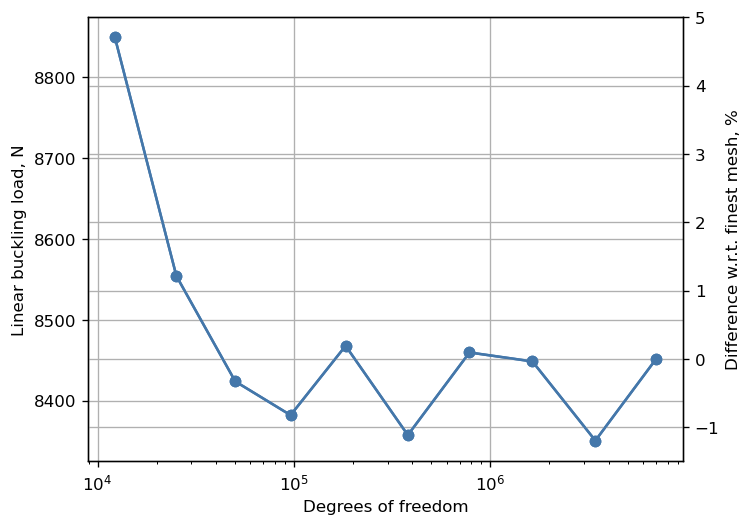

In [11]:
# Plot buckling loads vs degrees of freedom with a log scale along the x-axis
fig, ax1 = plt.subplots()  # create a figure and set of axes
buckling_load_line = ax1.semilogx(dofs, linear_buckling_loads, 'o-')

# Create a twin set of axes to plot percentage difference vs degrees of freedom
ax2 = ax1.twinx()
percentage_diff = (linear_buckling_loads/linear_buckling_loads[-1] - 1)*100
percentage_diff_line = ax2.plot(dofs, percentage_diff, 'o-')

# Set plot appearance
ax1.set_xlabel("Degrees of freedom")
ax1.set_ylabel("Linear buckling load, N")
ax2.set_ylabel("Difference w.r.t. finest mesh, %")
ax1.grid(True)
ax2.grid(True)
plt.show()


We see that the buckling load decreases monotonically for the first four meshes, and then it swings between approximately 8350 N and 8450 N. This behavior was not observed for th other versions of the box beam and as a consquence it could be ascribed to the discretization of the stiffeners. In fact, the points of the plot suggest the presence of two different convergence curves. The convergence to two different values is typical when using an even or an odd number of nodes, since the peak of the buckling mode will be represented differently in the two cases. However, the methodology used in our meshing functions enforce all edges to be discretized with an odd number of nodes, so the presence of two different convergence values in this case might be related to the ratio of nodes used to discretize the edges of the rib-stiffener bays.

Since we are happy with a linear buckling load that falls between the two apparent convergence curves, we define the mesh to be converged for the first target element length resulting in a percentage difference with respect to the finest mesh smaller than 1%.

In [12]:
converged_mesh_index = np.where(np.abs(percentage_diff) < 1)[0][0]  # first index of the element length array corresponding to where the percentage difference is below 1
converged_element_length = np.round(shell_element_lengths[converged_mesh_index], 1)  # round element length of converged mesh for consistency with future analyses
SOL_105_BUCKLING_LOAD = np.round(linear_buckling_loads[converged_mesh_index])  # round buckling load of converged mesh for consistency with future analyses
print(f"""
The mesh is converged for a prescribed shell element length of {converged_element_length:.1f} mm,
corresponidng to {no_elements[converged_mesh_index]} elements, {dofs[converged_mesh_index]:.0f} degrees of freedom
and to a linear buckling load of {SOL_105_BUCKLING_LOAD:.0f} N.""")


The mesh is converged for a prescribed shell element length of 47.0 mm,
corresponidng to 8784 elements, 50274 degrees of freedom
and to a linear buckling load of 8424 N.


We remind that the buckling load predicted by SOL 105 for the box beam reinforced with ribs only was 3101 N. As consequence, we can say that the addition of the stiffeners has more than doubled the linear buckling load.

## Nonlinear analysis: sensitivity of nonlinear analysis parameters <a name="nonlinear-analysis-parameters"></a>

***

Now we want to assess the influence of SOL 106's nonlinear analysis parameters on the results of the analysis. Analogously to what we did for the previous versions of our box beam, we are going to vary several parameters of the `NLPARM` and the `NLPCI` cards and observe how the load-displacement diagram changes, monitoring the tip displacement.

To perform our investigation we create a base bdf input of the box beam using the target element length obtained from the mesh convergence study and we set up SOL 106 with the arc-length method.

In [13]:
box_beam_mesh = box_beam_utils.mesh_box_beam_reinforced_with_ribs_and_stiffeners(
    width=w, height=h, ribs_y_coordinates=ribs_y_locations, stiffeners_x_coordinates=stiffeners_x_locations,
    stiffeners_height=stiffeners_height, element_length=converged_element_length)
nodes_xyz_array = box_beam_mesh.points
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]
box_beam_bdf = box_beam_utils.create_base_bdf_input(
    young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_xyz_array,
    nodes_connectivity_matrix=nodes_connectivity_matrix)
pynastran_utils.set_up_arc_length_method(box_beam_bdf)  # set up SOL 106 with arc-length method and default parameters

subcase=0 already exists...skipping


Then we apply the concentrated force at the tip and we define an applied load equal to twice the buckling load predicted by SOL 105.

In [14]:
TIP_MASTER_NODE_ID = apply_tip_concentrated_load(box_beam_bdf, force_set_id)
load_set_id = force_set_id + 1  # define id of load set
box_beam_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[SOL_105_BUCKLING_LOAD*2], load_ids=[force_set_id])  # add LOAD card to define load set with twice the buckling load predicted by SOL 105
pynastran_utils.create_static_load_subcase(bdf=box_beam_bdf, subcase_id=1, load_set_id=load_set_id)  # create subcase with defined load set

### Error function <a name="error-function"></a>

Let's start our investigation with the error function. We consider four different combinations of error functions:
- load and energy (default);
- load and energy with vector component checking;
- load and displacement;
- load and displacement with vector component checking;
- load, energy and displacement;
- load, energy and displacement with vector component checking.

In [15]:
error_functions = ['PW', 'PWV', 'PU', 'PUV', 'PWU', 'PWUV']

Since we need to plot the load-displacement diagram for different values of the nonlinear analysis parameters, we define a list of markers to use in the plots. We also define the function `plot_load_displacement_diagram` to run the Nastran analysis, read the load and displacement history from the op2 file and plot the load-displacement curve on a pre-defined figure, where the tip displacement $u_{z,\,tip}$ is nondimensionalized with the length $l$ of the box beam.

In [16]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles
from pyNastran.op2.op2 import read_op2

markers = list(Line2D.markers.keys())[2:]  # list of marker characters
Z_COMPONENT_INDEX = 2  # index of the z-component of vector quantities

def plot_load_displacement_diagram(bdf_input, filename, axes, marker_style, line_label, run_flag=True):
    # Run analysis
    pynastran_utils.run_analysis(directory_path=ANALYSIS_DIRECTORY_PATH, bdf=bdf_input, filename=filename,
                                 run_flag=run_flag)
    # Read load and displacement history from op2 file
    op2_path = os.path.join(ANALYSIS_DIRECTORY_PATH, filename + '.op2')
    op2 = read_op2(op2_path, debug=None)
    _, p, disp = pynastran_utils.read_load_displacement_history_from_op2(
        op2=op2, node_ids=[TIP_MASTER_NODE_ID])
    # Plot load-displacement curve on input axes
    axes.plot(disp[TIP_MASTER_NODE_ID][FIRST_SUBCASE_ID][:,Z_COMPONENT_INDEX]/l,#
              p[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/SOL_105_BUCKLING_LOAD,
              marker_style + '-', label=line_label)

Now let's run the analyses and plot the results.

Nastran job nonlinear_analysis_error_function_PW.bdf completed
Wall time: 48.0 s
Nastran job nonlinear_analysis_error_function_PWV.bdf completed
Wall time: 54.0 s
Nastran job nonlinear_analysis_error_function_PU.bdf completed
Wall time: 47.0 s
Nastran job nonlinear_analysis_error_function_PUV.bdf completed
Wall time: 46.0 s
Nastran job nonlinear_analysis_error_function_PWU.bdf completed
Wall time: 39.0 s
Nastran job nonlinear_analysis_error_function_PWUV.bdf completed
Wall time: 39.0 s


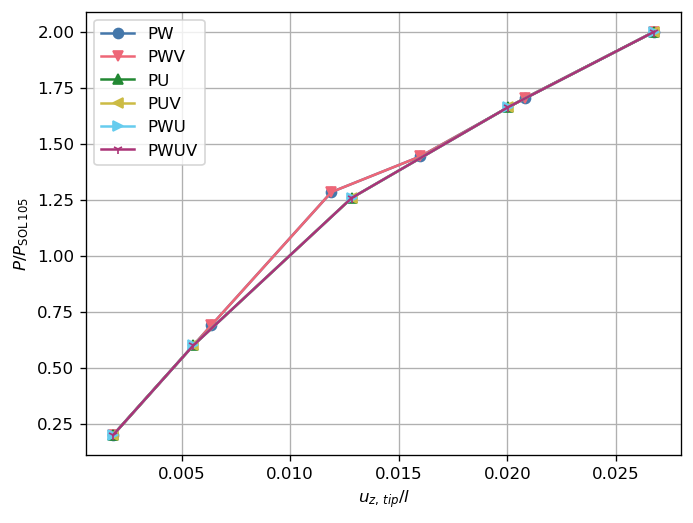

In [17]:
nlparm_id = next(iter(box_beam_bdf.nlparms))  # retrieve id of NLPARM card
_, ax = plt.subplots()  # create figure with one subplot

# Run analysis for each set of error functions and plot load-displacement diagram
for count, fun in enumerate(error_functions):
    box_beam_bdf.nlparms[nlparm_id].conv = fun
    input_name = "nonlinear_analysis_error_function_" + fun
    plot_load_displacement_diagram(box_beam_bdf, input_name, ax, markers[count], f"{fun}", run_flag=False)

# Set plot appearance
plt.xlabel("$u_{z,\,tip}/l$")
plt.ylabel("$P/P_\mathrm{SOL\,105}$")
plt.legend()
plt.grid()
plt.show()

The results appear to be influenced only by the presence of the displacement error function. In fact, two distinct sequences of equilibrium points can be observed, one resulting from the analyses including the displacement error function and another one resulting from the analyses not considering it. No difference can be observered within each group of analyses.

Since the analyses not considering the displacement error function result in one additional equilibrium point and thus in a finer resolution of the load-displacement curve, we select load and energy error functions and move on to the next parameter.

In [18]:
box_beam_bdf.nlparms[nlparm_id].conv = 'PW'

### Convergence tolerance <a name="convergence-tolerance"></a>

The second parameter that we consider is the convergence tolerance. Let's take three different combinations of load and displacement tolerances, taken from [table 21](https://help.hexagonmi.com/bundle/MSC_Nastran_2021.4/page/Nastran_Combined_Book/qrg/bulkno/TOC.NLPARM.xhtml) of MSC Nastran *Quick Reference Guide* manual on the default tolerances for static nonlinear SOL 106 models:
- $\mathrm{EPSP}=10^{-1},\,\mathrm{EPSW}=10^{-1}$;
- $\mathrm{EPSP}=10^{-2},\,\mathrm{EPSW}=10^{-3}$;
- $\mathrm{EPSP}=10^{-3},\,\mathrm{EPSW}=10^{-7}$.

Let's define the list of convergence tolerances, run the analyses and visualize the results.

Nastran job nonlinear_analysis_epsp1e-01.bdf completed
Wall time: 43.0 s
Nastran job nonlinear_analysis_epsp1e-02.bdf completed
Wall time: 46.0 s
Nastran job nonlinear_analysis_epsp1e-03.bdf completed
Wall time: 94.0 s


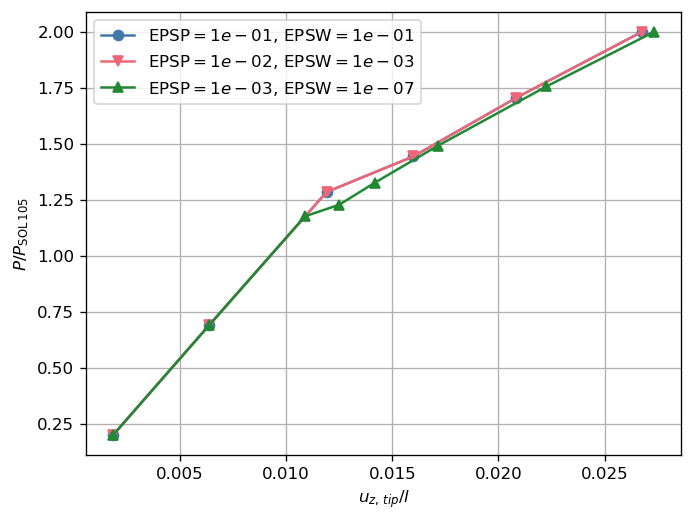

In [19]:
# Define error tolerances
load_tolerances = [1e-1, 1e-2, 1e-3]
energy_tolerances = [1e-1, 1e-3, 1e-7]

# Create figure, run analysis for each couple of convergence tolerances and plot load-displacement diagram
_, ax = plt.subplots()
for count, epsp in enumerate(load_tolerances):
    epsw = energy_tolerances[count]
    box_beam_bdf.nlparms[nlparm_id].eps_p = epsp
    box_beam_bdf.nlparms[nlparm_id].eps_w = epsw
    input_filename = f"nonlinear_analysis_epsp{epsp:.0e}".replace('.','_')
    plot_load_displacement_diagram(
        box_beam_bdf, input_filename, ax, markers[count], f"$\mathrm{{EPSP}}={epsp:.0e},\,\mathrm{{EPSW}}={epsw:.0e}$", run_flag=False)

# Set plot appearance
plt.xlabel("$u_{z,\,tip}/l$")
plt.ylabel("$P/P_\mathrm{SOL\/105}$")
plt.legend()
plt.grid()
plt.show()

We observe that the tightest convergence tolerances results in a different load-displacement curve for $P/P_\text{SOL 105}>1$ that has a finer resolution, and for this reason we keep those convergence tolerances for the successive analyses.

In [20]:
box_beam_bdf.nlparms[nlparm_id].eps_p = 1e-3
box_beam_bdf.nlparms[nlparm_id].eps_w = 1e-7

### Initial load increment <a name="initial-load-increment"></a>

Now we consider three different values of initial load increment:
- $\Delta\mu^1=0.5$;
- $\Delta\mu^1=0.1$ (default);
- $\Delta\mu^1=0.01$.

Nastran job nonlinear_analysis_initial_load_increment5e-01.bdf completed
Wall time: 23.0 s
Nastran job nonlinear_analysis_initial_load_increment1e-01.bdf completed
Wall time: 87.0 s
Nastran job nonlinear_analysis_initial_load_increment1e-02.bdf completed
Wall time: 56.0 s


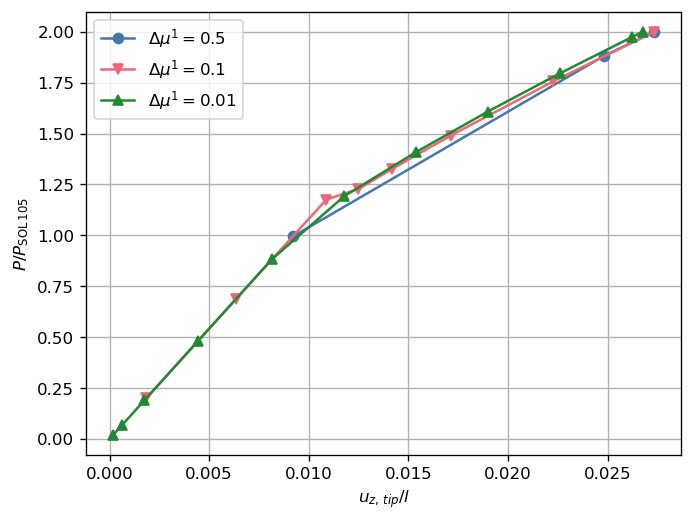

In [21]:
initial_load_increments = [.5, .1, .01]  # define list of initial load increments

# Create figure, run analysis for each initial load increment and plot load-displacement diagram
_, ax = plt.subplots()
for count, delta_mu_1 in enumerate(initial_load_increments):
    box_beam_bdf.nlparms[nlparm_id].ninc = round(1/delta_mu_1)
    input_filename = f"nonlinear_analysis_initial_load_increment{delta_mu_1:.0e}".replace('.','_')
    plot_load_displacement_diagram(box_beam_bdf, input_filename, ax, markers[count], f"$\Delta\mu^1={delta_mu_1:.9g}$", run_flag=False)

# Set plot appearance
plt.xlabel("$u_{z,\,tip}/l$")
plt.ylabel("$P/P_\mathrm{SOL\/105}$")
plt.legend()
plt.grid()
plt.show()

For $P/P_\text{SOL 105}\leq 1$ the equilibrium points of all analyses appear to lie on the same load-displacement curve. For $P/P_\text{SOL 105}>1$, the equilibrium points found with $\Delta\mu^1=0.5$ and $0.1$ seem to approximately lie on the same load-displacement curve, while the analysis employing $\Delta\mu^1=0.01$ appears to result in a different, more well-resolved load-displacement curve.

Consequently, we keep $\Delta\mu^1=0.01$ for our successive analyses.

### Desired number of iterations <a name="desiter"></a>

Now we investigate the influence of the desired number of iterations, using the following values:
- $I_d=20$;
- $I_d=12$ (default);
- $I_d=5$.

Nastran job nonlinear_analysis_desiter20.bdf completed
Wall time: 76.0 s
Nastran job nonlinear_analysis_desiter12.bdf completed
Wall time: 58.0 s
Nastran job nonlinear_analysis_desiter5.bdf completed
Wall time: 79.0 s


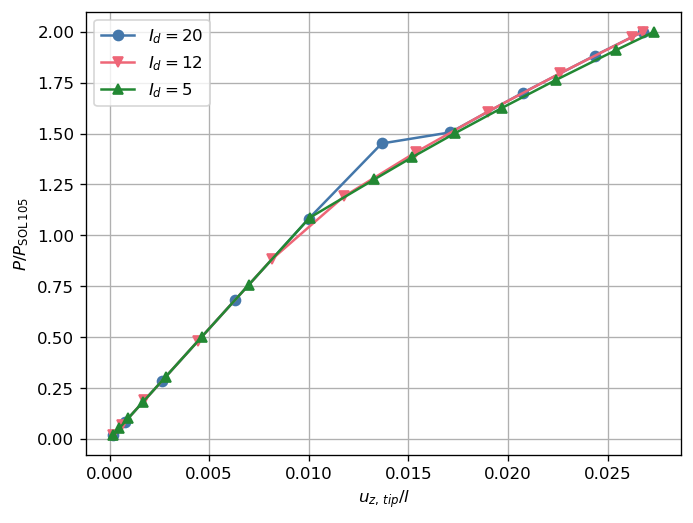

In [22]:
no_iterations = [20, 12, 5]  # define list of desired numbers of iterations

# Create figure, run analysis for each desired number of iterations, plot load-displacement diagram
_, ax = plt.subplots()
for count, desiter in enumerate(no_iterations):
    box_beam_bdf.nlpcis[nlparm_id].desiter = desiter
    input_filename = f"nonlinear_analysis_desiter{desiter:d}"
    plot_load_displacement_diagram(box_beam_bdf, input_filename, ax, markers[count], f"$I_d={desiter}$", run_flag=False)

# Set plot appearance
plt.xlabel("$u_{z,\,tip}/l$")
plt.ylabel("$P/P_\mathrm{SOL\/105}$")
plt.legend()
plt.grid()
plt.show()

The equilibrium points calculated by the analyses with $I_d=20$ and $I_d=12$ appear to result in the same final equilibrium point, while the analysis employing $I_d=5$ results in a different final equilibrium point. Furthermore, the equilibrium points of the latter analysis appear to diverge from the other two analyses for the largest load increments.

The curve obtained with $I_d=5$ is the most well-resolved, and for this reason we keep $I_d=5$ for our successive analyses.

### Minimum allowable arc-length adjustment ratio <a name="minalr"></a>

Next, we assess the effect of the minimum allowable arc-length adjustment ratio, investigating three values:
- $\mathrm{MINALR}=0.9$;
- $\mathrm{MINALR}=0.25$ (default);
- $\mathrm{MINALR}=0.01$.

Nastran job nonlinear_analysis_minalr0_9.bdf completed
Wall time: 72.0 s
Nastran job nonlinear_analysis_minalr0_25.bdf completed
Wall time: 76.0 s
Nastran job nonlinear_analysis_minalr0_01.bdf completed
Wall time: 78.0 s


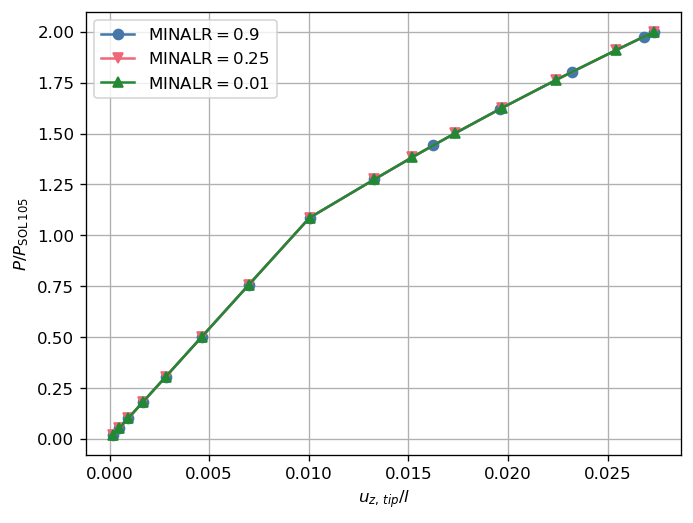

In [23]:
min_arclength_adjustment_ratios = [.9, .25, .01]  # define list of minimum allowable arc-length adjustment ratios

# Create figure, run analysis for each minimum allowable arc-length adjustment ratio and plot load-displacement diagram
_, ax = plt.subplots()
for count, minalr in enumerate(min_arclength_adjustment_ratios):
    box_beam_bdf.nlpcis[nlparm_id].minalr = minalr
    input_filename = f"nonlinear_analysis_minalr{minalr:.9g}".replace('.','_')
    plot_load_displacement_diagram(box_beam_bdf, input_filename, ax, markers[count], f"$\mathrm{{MINALR}}={minalr:.9g}$", run_flag=False)

# Set plot appearance
plt.xlabel("$u_{z,\,tip}/l$")
plt.ylabel("$P/P_\mathrm{SOL\/105}$")
plt.legend()
plt.grid()
plt.show()

In this case we cannot see any effect on the load-displacement curve,  so we switch back to the default value.

In [24]:
box_beam_bdf.nlpcis[nlparm_id].minalr = .25

### Maximum allowable arc-length adjustment ratio <a name="maxalr"></a>

Finally, we consider three different maximum allowable arc-length adjustment ratios:
- $\mathrm{MAXALR}=8$;
- $\mathrm{MAXALR}=4$ (default);
- $\mathrm{MAXALR}=1.01$;
- $\mathrm{MAXALR}=1.0001$.

To run this set of analyses we need to increase the maximum number of allowed increments to 200, since the analyses with the smallest values of $\mathrm{MAXALR}$ do not converge with the default value of 20.

Nastran job nonlinear_analysis_maxalr8.bdf completed
Wall time: 74.0 s
Nastran job nonlinear_analysis_maxalr4.bdf completed
Wall time: 76.0 s
Nastran job nonlinear_analysis_maxalr1_01.bdf completed
Wall time: 294.0 s
Nastran job nonlinear_analysis_maxalr1_0001.bdf completed
Wall time: 422.0 s


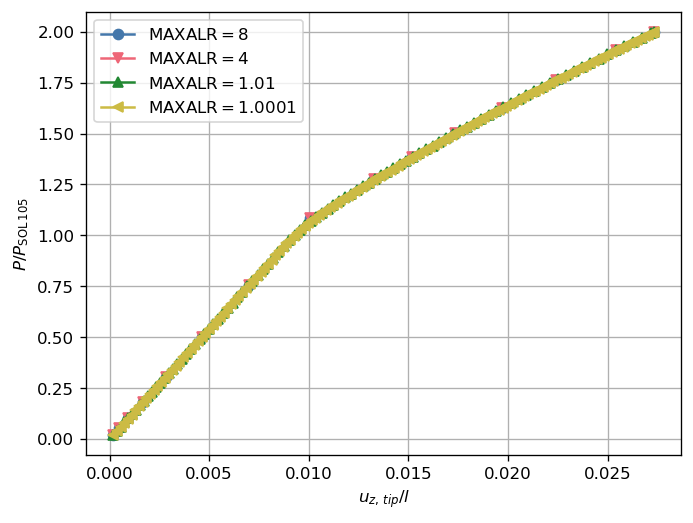

In [25]:
max_arclength_adjustment_ratios = [8., 4., 1.01, 1.0001]  # define list of maximum allowable arc-length adjustment ratios
box_beam_bdf.nlpcis[nlparm_id].mxinc = 200  # increase maximum number of load increments

# Create figure, run analysis for each maximum allowable arc-length adjustment ratio and plot load-displacement diagram
_, ax = plt.subplots()
for count, maxalr in enumerate(max_arclength_adjustment_ratios):
    box_beam_bdf.nlpcis[nlparm_id].maxalr = maxalr
    input_filename = f"nonlinear_analysis_maxalr{maxalr:.9g}".replace('.','_')
    plot_load_displacement_diagram(box_beam_bdf, input_filename, ax, markers[count], f"$\mathrm{{MAXALR}}={maxalr:.9g}$", run_flag=False)

# Set plot appearance
plt.xlabel("$u_{z,\,tip}/l$")
plt.ylabel("$P/P_\mathrm{SOL\/105}$")
plt.legend()
plt.grid()
plt.show()

Also in this case the equilibrium points of all analyses appear to describe the same curve. As expected, the analyses with the smallest values of $\mathrm{MAXALR}$ result in a finer resolution of the load-displacement curve.

With our final set of nonlinear analysis parameters, we can make a final observation on the load-displacement diagram. The curve appears to be linear below and above $P/P_\text{SOL 105}=1$ with a clear kink at such applied load. This evidence suggests that some nonlinearity has come into play. For this reason we inspect the static deformation of the box beam for $P/P_\text{SOL 105}=2$.

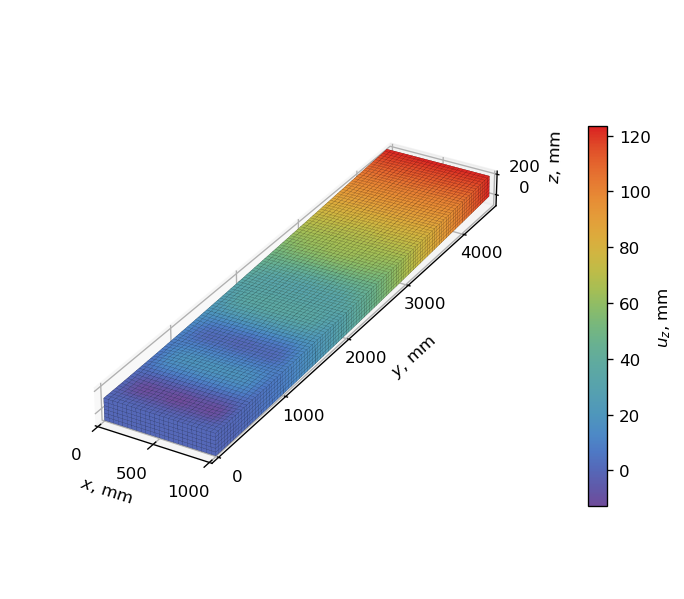

In [26]:
input_filename = f"nonlinear_analysis_maxalr{max_arclength_adjustment_ratios[-1]:.9g}".replace('.','_')
op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_filename + '.op2')
sol_106_op2 = read_op2(op2_filepath, debug=None, load_geometry=True)
_, ax, cbar = plot_utils.plot_deformation(sol_106_op2, displacement_component='tz', length_unit="mm")
adjust_3d_plot(ax, cbar)
plt.show()

We observe that the top skin has indeed assumed a buckled-like shape, with alternating positive and negative out-of-plane displamecements over the inboard rib bays. As a consequence, the change of slope in the load-displacement diagram can be ascribed to the change of shape of the top skin as the box beam is loaded beyond $P/P_\text{SOL 105}=1$.

## Nonlinear analysis: nonlinear buckling method verification <a name="nonlinear-buckling-method-verification"></a>

***

The next step of our ivestigation consist in the verification of SOL 106's nonlinear buckling method and of the stability of the equilibrium path found earlier. As far as the former is concerned, we want to verify whether the nonlinear buckling method is able to predict the same critical load predicted by SOL 105 for the linear range of the structural response below $P/P\text{SOL 105}=1$. For the latter, we need to monitor the lowest eigenvalues of the tangent stiffness matrix and check whether they are always positive.

Similarly to what we did in our previous notebooks, we define 11 load magnitudes equally spaced between 0 and twice the linear buckling load. We discard the load case with null magnitude, we keep the other 10 load cases and define the corresponding subcases.

In [27]:
# Define and print the sequence of increasing applied loads
applied_load_magnitudes = np.linspace(0, 2*SOL_105_BUCKLING_LOAD, 11)[1:]
np.set_printoptions(precision=0, suppress=True)
print(f"Applied loads [N]: {applied_load_magnitudes}")

# Change first load magnitude of first subcase
box_beam_bdf.load_combinations[load_set_id][0].scale_factors[0] = applied_load_magnitudes[0]

# Create LOAD card and corresponding subcases for remaining applied loads
for i, scale_factor in enumerate(applied_load_magnitudes[1:], start=2):
    load_set_id = load_set_id + 1
    box_beam_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor], load_ids=[force_set_id])
    pynastran_utils.create_static_load_subcase(bdf=box_beam_bdf, subcase_id=i, load_set_id=load_set_id)

Applied loads [N]: [ 1685.  3370.  5054.  6739.  8424. 10109. 11794. 13478. 15163. 16848.]


Let's use a value of $\mathrm{MAXALR}=1.01$ as a compromise between resolution of the load-displacement curve and computational time.

In [28]:
box_beam_bdf.nlpcis[nlparm_id].maxalr = 1.01

Then we add the parameters needed to execute the nonlinear buckling method.

In [29]:
box_beam_bdf.add_param('BUCKLE', [2])
eigrl_set_id = load_set_id + 1
box_beam_bdf.add_eigrl(sid=eigrl_set_id, v1=0., nd=1)  # calculate only the first positive eigenvalue
box_beam_bdf.case_control_deck.subcases[0].add_integer_type('METHOD', eigrl_set_id)

We also add the DMAP sequence to calculate the lowest eigenvalue of the tangent stiffness matrix at every converged increment.

In [30]:
box_beam_bdf.executive_control_lines[1:1] = [
    'include \'' + os.path.join(os.pardir, os.pardir, 'resources', 'kllrh_eigenvalues.dmap') + '\'']  # include DMAP sequence

And we can finally run our nonlinear analysis.

In [31]:
input_name = "nonlinear_buckling_verification"
pynastran_utils.run_analysis(directory_path=ANALYSIS_DIRECTORY_PATH, bdf=box_beam_bdf, filename=input_name, run_flag=False)

Nastran job nonlinear_buckling_verification.bdf completed
Wall time: 3064.0 s


Let's plot the results in terms of buckling load predicted by SOL 106 and critical buckling factor against the applied load.

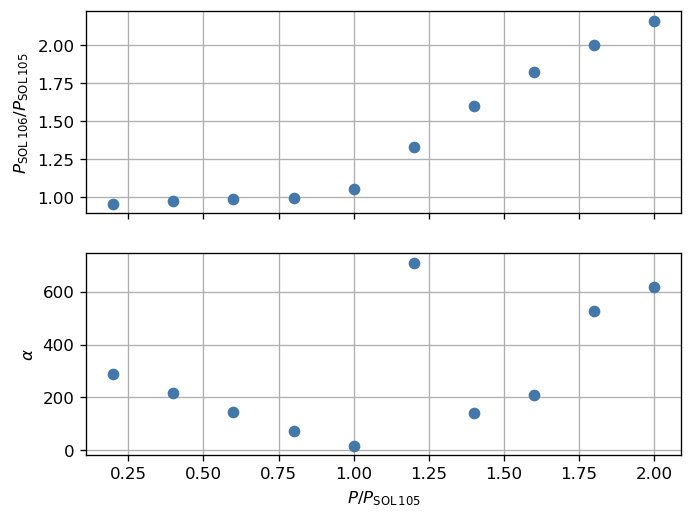

In [32]:
# Read op2 file
op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2')
sol_106_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)

# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_load_vectors, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(
    f06_filepath=os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06'), op2=sol_106_op2)  # read buckling loads and critical buckling factors from f06 file
sol_106_buckling_loads = np.linalg.norm(np.sum(nonlinear_buckling_load_vectors[:, :, 0:3], axis=1), axis=1)  # calculate the norm of the nonlinear buckling load vector for each subcase

# Plot results
plt.rcParams['figure.dpi'] = 120  # set default dpi of figures
_, axs = plt.subplots(nrows=2, ncols=1, sharex='all')  # figure with 2 subplots
axs[0].plot(applied_load_magnitudes/SOL_105_BUCKLING_LOAD, sol_106_buckling_loads/SOL_105_BUCKLING_LOAD, 'o')  # buckling loads vs applied loads
axs[1].plot(applied_load_magnitudes/SOL_105_BUCKLING_LOAD, critical_buckling_factors, 'o')  # critical buckling factors vs applied loads

# Set plot appearance
axs[0].set_ylabel("$P_\mathrm{SOL\/106}/P_\mathrm{SOL\/105}$")
axs[0].grid(visible=True)
axs[1].set_ylabel("$\\alpha$")
axs[1].grid(visible=True)
axs[1].set_xlabel("$P/P_\mathrm{SOL\/105}$")
plt.show()

We observe that the nonlinear buckling method predicts approximately the same critical buckling load as SOL 105 for $P/P_\text{SOL 105}<1$. For $P/P_\text{SOL 105}\geq 1$ there seems to be almost a linear relationship between the nonlinear buckling load and the applied load. This is analogous to the results of the other box beam configurations. Once again the results suggest that the structure follows an equilibrium path similar to the natural path of a broken supercritical pitchfork.

Let's plot the load-displacement diagram and the smallest magnitude eigenvalue $\lambda$ of the tangent stiffness matrix against the applied load to verify that the structure is always in a stable equilibrium.

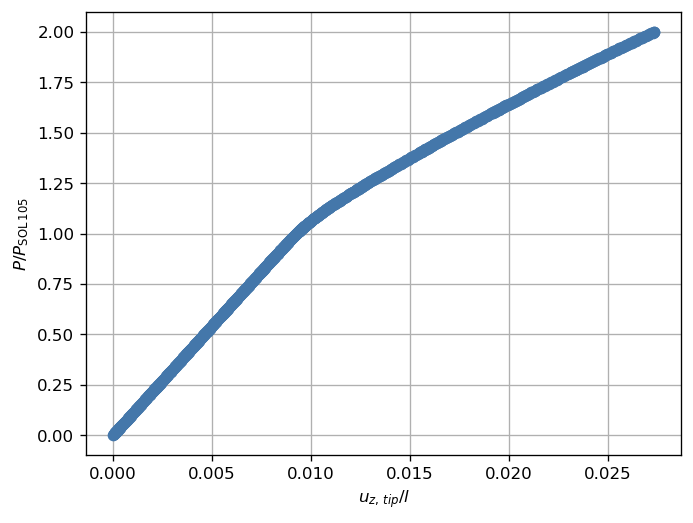

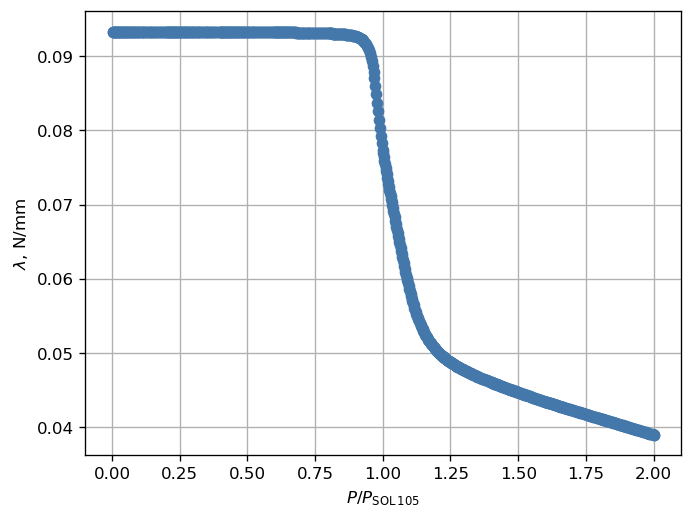

In [33]:
# Plot load-displacement diagram
_, applied_loads, dispalcements = pynastran_utils.read_load_displacement_history_from_op2(
    op2=sol_106_op2, node_ids=[TIP_MASTER_NODE_ID])  # read load and displacement history
tip_displacements = dispalcements[TIP_MASTER_NODE_ID]  # extract tip displacements
load_history = np.concatenate([applied_loads[subcase_id][:, Z_COMPONENT_INDEX] for subcase_id in applied_loads])
displacement_history = np.concatenate([tip_displacements[subcase_id][:, Z_COMPONENT_INDEX] for subcase_id in tip_displacements])
_, ax = plt.subplots()
ax.plot(displacement_history/l, load_history/SOL_105_BUCKLING_LOAD, 'o')
plt.xlabel("$u_{z,\,tip}/l$")
plt.ylabel("$P/P_\mathrm{SOL\,105}$")
plt.grid()
plt.show()

# Plot lowest eigenvalue of tangent stiffness matrix
f06_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)  # read eigenvalues from f06 files
_, ax = plt.subplots()
ax.plot(load_history/SOL_105_BUCKLING_LOAD, eigenvalues[0, :], 'o')
plt.xlabel("$P/P_\mathrm{SOL\,105}$")
plt.ylabel("$\lambda$, N/mm")
plt.grid()
plt.show()

The smallest magnitude eigenvalue is constant up to a load slightly smaller than $P/P_\text{SOL 105}=1$, where it undergoes an abrupt decrease. This must correspond to the top skin assuming a buckled-like shape and consequently inducing a nonlinearity in the global behavior of the structure. However, likewise the other box beam configurations, the smallest magnitude eigenvalue never becomes negative, meaning that the structure does not encounter a critical point and that it always stays in a stable equilibrium configuration.

## Conclusion <a name="conclusion"></a>

***

In this notebook we have investigated the nonlinear behavior of a box beam reinforced with ribs and stiffeners. The results show a bifurcation break analogously to the previous cases of the unreinforced box beam and of the box beam reinforced with ribs only.